---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Blight Fines Compliance Predictor

**Based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)).** 

Detroit faces the problem of Blight violations (these are issued by the city to individuals who allow their properties to remain in a deteriorated condition). Unfortunately, many of the fines issued by the city of Detroit remain unpaid. **"Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?".**

In order to answering this question, we need first to understand when and why a resident might fail to comply with a blight ticket.

**Our Goal: Predict whether a given blight ticket will be paid on time.**

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [1]:
import pandas as pd
import numpy as np

## Open train and test data files
## Target variable COMPLIANCE (True: Ticket paid on time; False: Ticket paid after the hearing date or not at all;
## Null: violator was found not responsible)
train = pd.read_csv('train.csv',encoding='ISO-8859-1')

#! cat readonly/test.csv > test.csv
test = pd.read_csv('test.csv', encoding='cp1252')

#! cat readonly/latlons.csv > latlons.csv
latlon = pd.read_csv('latlons.csv')

#! cat readonly/addresses.csv > addresses.csv
address = pd.read_csv('addresses.csv')

#Check dataframes's initial columns and shapes
print(train.columns)
print(test.columns)
print(latlon.columns)
print(address.columns)
print(train.shape)
print(test.shape)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')
Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_dat

In [2]:
#Drop null-values compliance (NaN)
train = train.dropna(subset=['compliance'])

#Drop all columns with NaN
train = train.dropna(axis = 1,how  = 'all')
#print(train.shape)

<IPython.core.display.Javascript object>


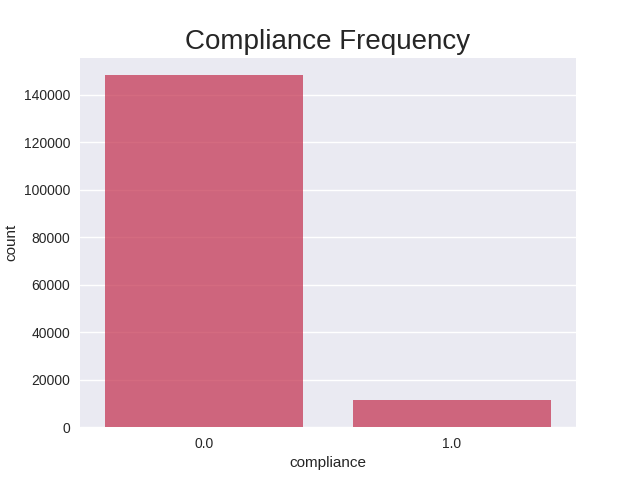

In [3]:
# Plotting compliance frequency per class
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

sns.countplot(train['compliance'], color='crimson', alpha=0.7).set_title("Compliance Frequency", size=20)

In [4]:
#Calculate total and percent missing data per features
percentagenull = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([percentagenull], axis=1, keys = ['Percent'])
missing_data.head(5)

,Percent
non_us_str_code,0.999981
collection_status,0.769221
payment_date,0.752245
mailing_address_str_number,0.015999
hearing_date,0.001420


In [5]:
#Get rid of columns with >50% missing data
train.drop(missing_data[missing_data['Percent']>0.5].index,axis = 1,inplace = True)

In [6]:
#Delete columns which have all values same
length = len(train.columns)
for i in range (length):
    if len(train[train.columns[i]].unique()) == 1:
         print(train.columns[i])
            
train.drop(labels = 'clean_up_cost' ,axis = 1,inplace = True)
test.drop(labels = 'clean_up_cost' ,axis = 1,inplace = True)
train.drop(labels = 'state_fee' ,axis = 1,inplace = True)
test.drop(labels = 'state_fee' ,axis = 1,inplace = True)
train.drop(labels = 'admin_fee' ,axis = 1,inplace = True)
test.drop(labels = 'admin_fee' ,axis = 1,inplace = True)

admin_fee
state_fee
clean_up_cost


In [7]:
#Merge train/test and (address + latlon) dataframes
train = pd.merge(train, pd.merge(latlon, address, how='inner', on = 'address'), on = 'ticket_id')
test = pd.merge(test, pd.merge(latlon, address, how='inner', on = 'address'), on = 'ticket_id')
print(train.shape)
print(test.shape)

(159880, 29)
(61001, 27)


In [8]:
# Let's check again new dataframe's features
print(train.columns)
print(test.columns)

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'late_fee', 'discount_amount', 'judgment_amount', 'payment_amount',
       'balance_due', 'payment_status', 'compliance_detail', 'compliance',
       'address', 'lat', 'lon'],
      dtype='object')
Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'late_fee', 'discount_

In [9]:
# Remove useless variables from both train and test dataframes
remove = ['balance_due', 'payment_status', 'compliance_detail', 'agency_name', 'inspector_name', 
'violator_name', 'violation_street_name', 'mailing_address_str_name', 'city', 'violation_street_number',
 'state', 'zip_code', 'country',  'ticket_issued_date', 'hearing_date', 'violation_description',
 'discount_amount', 'payment_amount', 'disposition', 'address', 'violation_code', 'mailing_address_str_number']

removetest = ['non_us_str_code', 'agency_name', 'inspector_name', 'violator_name', 'violation_street_name', 
              'mailing_address_str_name', 'city', 'violation_street_number','state', 'zip_code', 'country', 
              'ticket_issued_date', 'hearing_date', 'violation_description', 'discount_amount',
             'grafitti_status', 'violation_zip_code', 'disposition', 'address', 'violation_code', 'mailing_address_str_number']
train.drop(remove, axis = 1, inplace = True)
test.drop(removetest, axis = 1, inplace = True)
print(train.shape)
print(test.shape)

(159880, 7)
(61001, 6)


In [10]:
## Fill lat and long missing values with mean of the feature 
test['lat'] = test['lat'].fillna(test['lat'].mean())
train['lat'] = train['lat'].fillna(train['lat'].mean())

test['lon'] = test['lon'].fillna(test['lon'].mean())
train['lon'] = train['lon'].fillna(train['lon'].mean())

print(train.isnull().sum())
print(test.isnull().sum())

ticket_id          0
fine_amount        0
late_fee           0
judgment_amount    0
compliance         0
lat                0
lon                0
dtype: int64
ticket_id          0
fine_amount        0
late_fee           0
judgment_amount    0
lat                0
lon                0
dtype: int64


In [11]:
#Set target value
y_train = train['compliance']
# Drop target value from training dataframe
X_train = train.drop(['compliance'], axis=1)
#Dataframe to test the model
X_test = test

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

#Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Evaluation ##

Predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric will be the Area Under the ROC Curve (AUC). 

**Goal:** A model with an AUCROC over 0.75

**Hint:** The total runtime should be less than 10 mins

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

#Let's fit a Dummy model in order to make future comparisons
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
y_majority_predicted = dummy_majority.predict(X_test)
print('Accuracy of Dummy classifier on training set: {:.2f}'
     .format(dummy_majority.score(X_train_scaled, y_train)))
print('Accuracy of Dummy classifier on test set: {:.2f}'
     .format(dummy_majority.score(X_test_scaled, y_test)))
print('ROC AUC score Dummy classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, y_majority_predicted)))

Accuracy of Dummy classifier on training set: 0.93
Accuracy of Dummy classifier on test set: 0.93
ROC AUC score Dummy classifier on test set: 0.50


In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Running K-nearest neighbors model
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
ypred = knn.predict(X_test)

print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))
print('ROC AUC score K-NN classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, ypred)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.93
ROC AUC score K-NN classifier on test set: 0.50


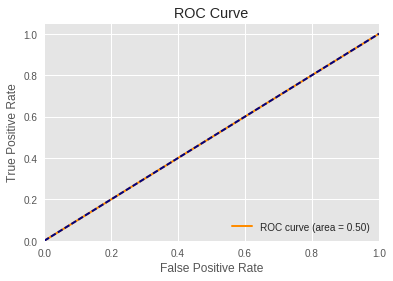

In [42]:
#KNN ROC Curve Plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, _ = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN Model')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train, y_train)
ypred = clf.predict(X_test)

# Running Support Vector Machines Model
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print('ROC AUC score Linear SVC classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, ypred)))

Accuracy of Linear SVC classifier on training set: 0.93
Accuracy of Linear SVC classifier on test set: 0.93
ROC AUC score Linear SVC classifier on test set: 0.50


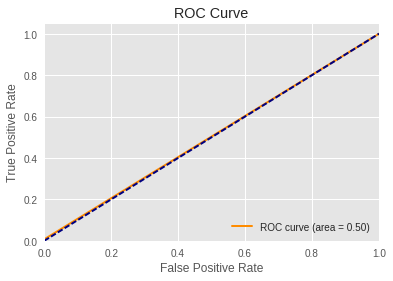

In [37]:
#SVM ROC Curve Plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, _ = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM Model')
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


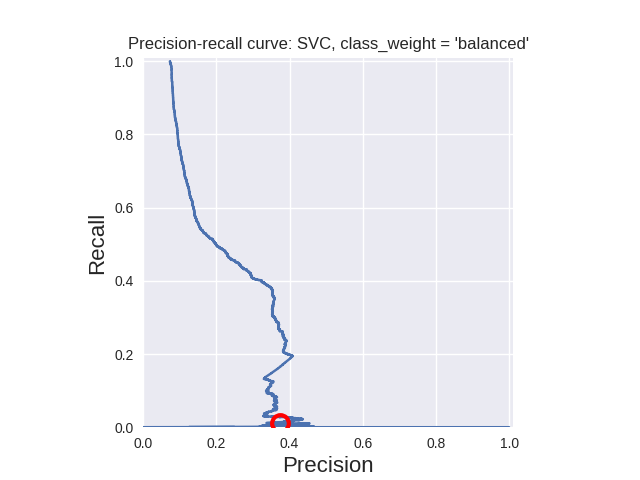

At zero threshold, precision: 0.37, recall: 0.01


In [16]:
#SVC Precision-Recall Curve

from sklearn.metrics import precision_recall_curve
from adspy_shared_utilities import plot_class_regions_for_classifier

y_scores = clf.decision_function(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.title ("Precision-recall curve: SVC, class_weight = 'balanced'")
plt.plot(precision, recall, label = 'Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize=12, fillstyle='none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()
print('At zero threshold, precision: {:.2f}, recall: {:.2f}'
      .format(closest_zero_p, closest_zero_r))

In [17]:
from sklearn.neural_network import MLPClassifier

#Running Neural Network Model 
clf = MLPClassifier(hidden_layer_sizes = [10, 10], alpha = 0.01,
                   random_state = 0, solver = 'lbfgs').fit(X_train_scaled, y_train)
ypred = clf.predict(X_test)
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
print('ROC AUC score NN classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, ypred)))

Accuracy of NN classifier on training set: 0.93
Accuracy of NN classifier on test set: 0.93
ROC AUC score NN classifier on test set: 0.50


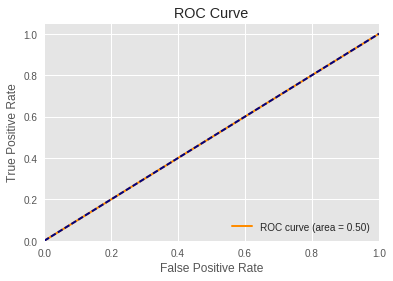

In [35]:
#MLP ROC Curve Plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, _ = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Neural Network Model')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.ensemble import RandomForestRegressor

#Running Random Forest Model 
reg = RandomForestRegressor(max_depth = 10,random_state=0).fit(X_train, y_train)
ypred = reg.predict(X_test)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))
print('ROC AUC score of RF classifier on test set: {:.2f}'
     .format(roc_auc_score(y_test, ypred)))
#WE GOT THE BEST ROC AUC SCORE! 

Accuracy of RF classifier on training set: 0.93
Accuracy of RF classifier on test set: 0.93
ROC AUC score of RF classifier on test set: 0.79


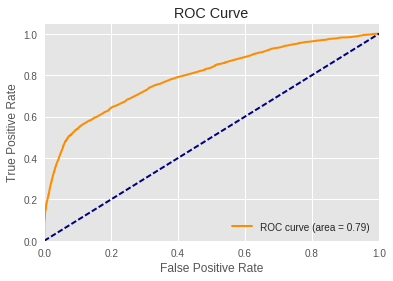

In [40]:
#Random Forest ROC Curve Plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fpr, tpr, _ = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest Model')
plt.legend(loc="lower right")
plt.show()

In [19]:
from sklearn.model_selection import  GridSearchCV

#Grid Search for finding Optimal Values
reg = RandomForestRegressor(max_depth = 10,random_state=0).fit(X_train, y_train)
grid_values = {'n_estimators': [10, 100], 'max_depth': [None, 30]}
grid_clf_auc = GridSearchCV(reg, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train, y_train)
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Grid best parameter (max. AUC):  {'max_depth': 30, 'n_estimators': 100}
Grid best score (AUC):  0.800475783592


<IPython.core.display.Javascript object>


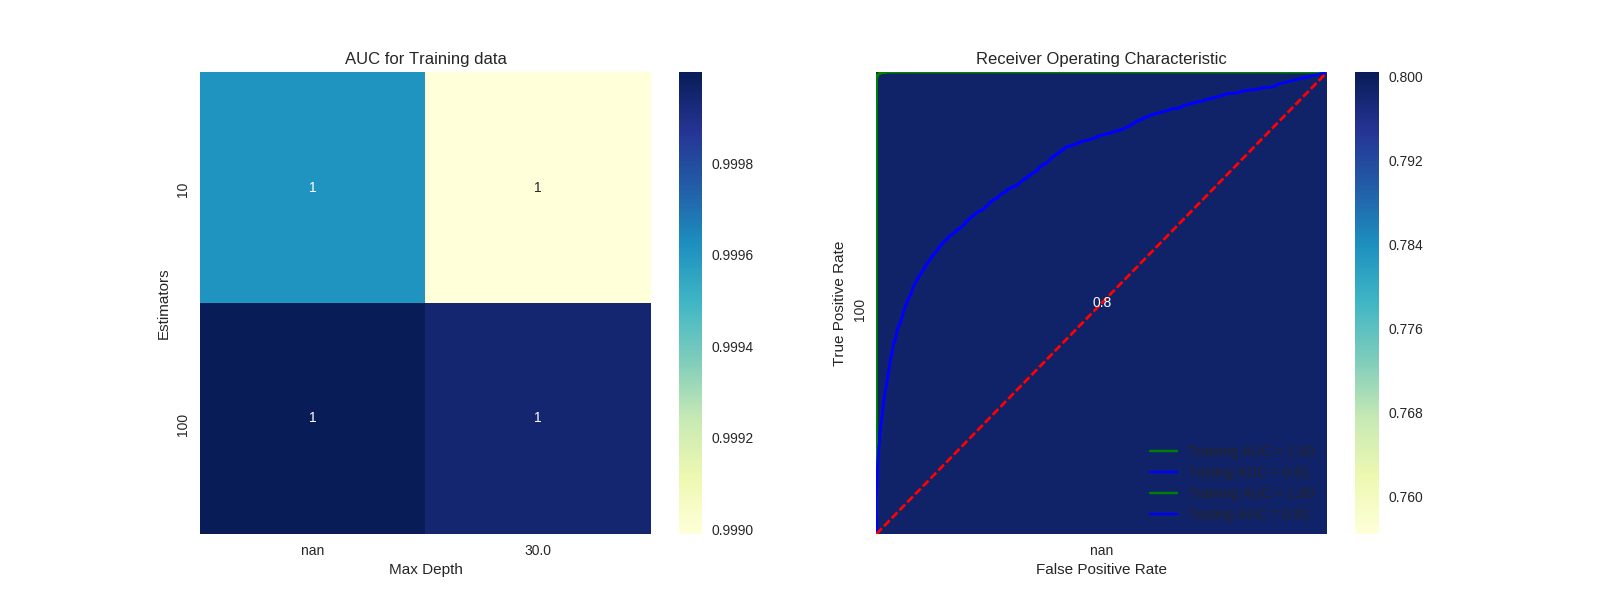

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

#Estimators = [10, 100] 
#max_depths = [None, 30] 

#grid_values = {'n_estimators': [10, 100], 'max_depth': [None, 30]}
#clf = GridSearchCV(reg, param_grid=grid_values, scoring='roc_auc')
#clf.fit(X_train, y_train)
best_n_estimators_value = grid_clf_auc.best_params_['n_estimators']
best_max_depth_value = grid_clf_auc.best_params_['max_depth']
best_score = grid_clf_auc.best_score_

max_depth_list = list(grid_clf_auc.cv_results_['param_max_depth'].data)
estimators_list = list(grid_clf_auc.cv_results_['param_n_estimators'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training data')
plt.subplot(1,2,2)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

In [44]:
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.style.use('ggplot')    
    plt.title('ROC Curve Random Forest Model Best Hyperparameters')
    plt.plot(fpr_tr, tpr_tr, 'g', color = 'darkorange', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

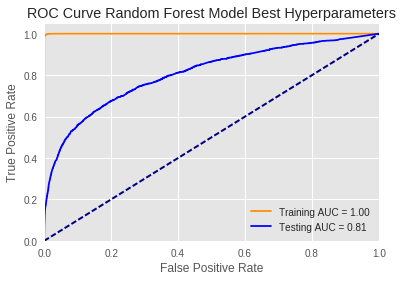

In [45]:
#Random Forest (after Grid Search) ROC Curve Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Best hyper parameter 

clf = RandomForestRegressor(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value)

clf.fit(X_train_scaled, y_train)

y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)


#train data ROC
fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(fpr_tr, tpr_tr)

#test data ROC
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(fpr_ts, tpr_ts)

#Plot ROC curve
plot_roc_curve(roc_auc_train, roc_auc_test)

In [53]:
## Let's create a DataFrame with Random Forest results
df = pd.DataFrame(grid_clf_auc.predict(test), test.ticket_id)

In [2]:
# Let's create a function that trains a model to predict blight ticket compliance in Detroit, this will return 
# a serires with the data being the probability that each corresponding ticket will be paid.

#def blight_model():
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import roc_auc_score


    train = pd.read_csv('train.csv',encoding='ISO-8859-1')
    test = pd.read_csv('test.csv', encoding='cp1252')
    latlon = pd.read_csv('latlons.csv')
    address = pd.read_csv('addresses.csv')
    
    for i in range(len(train.columns)): 
        if len(train[train.columns[i]].unique()) < 250:
            train[train.columns[i]] = train[train.columns[i]] .astype('category')
        
    train = train.dropna(subset=['compliance'])
    train = train.dropna(axis = 1,how  = 'all')

    percentagenull = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
    missing_data = pd.concat([percentagenull], axis=1, keys = ['Percent'])
    
    train.drop(missing_data[missing_data['Percent']>0.5].index,axis = 1,inplace = True)
            
    train.drop(labels = 'clean_up_cost' ,axis = 1,inplace = True)
    test.drop(labels = 'clean_up_cost' ,axis = 1,inplace = True)
    train.drop(labels = 'state_fee' ,axis = 1,inplace = True)
    test.drop(labels = 'state_fee' ,axis = 1,inplace = True)
    train.drop(labels = 'admin_fee' ,axis = 1,inplace = True)
    test.drop(labels = 'admin_fee' ,axis = 1,inplace = True)
    
    train = pd.merge(train, pd.merge(latlon, address, how='inner', on = 'address'), on = 'ticket_id')
    test = pd.merge(test, pd.merge(latlon, address, how='inner', on = 'address'), on = 'ticket_id')
    
    remove = ['balance_due', 'payment_status', 'compliance_detail', 'agency_name', 'inspector_name', 
              'violator_name', 'violation_street_name', 'mailing_address_str_name', 'city', 'violation_street_number',
              'state', 'zip_code', 'country',  'ticket_issued_date', 'hearing_date', 'violation_description',
              'discount_amount', 'payment_amount', 'disposition', 'address', 'violation_code', 'mailing_address_str_number']

    removetest = ['non_us_str_code', 'agency_name', 'inspector_name', 'violator_name', 'violation_street_name', 
                  'mailing_address_str_name', 'city', 'violation_street_number','state', 'zip_code', 'country', 
                  'ticket_issued_date', 'hearing_date', 'violation_description', 'discount_amount',
                 'grafitti_status', 'violation_zip_code', 'disposition', 'address', 'violation_code', 'mailing_address_str_number']
    
    train.drop(remove, axis = 1, inplace = True)
    test.drop(removetest, axis = 1, inplace = True)
    
    test['lat'] = test['lat'].fillna(test['lat'].mean())
    train['lat'] = train['lat'].fillna(train['lat'].mean())

    test['lon'] = test['lon'].fillna(test['lon'].mean())
    train['lon'] = train['lon'].fillna(train['lon'].mean())
    
    y_train = train['compliance']
    X_train = train.drop(['compliance'], axis=1)
    X_test = test
    
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    reg = RandomForestRegressor(max_depth = 10,random_state=0).fit(X_train, y_train)
    grid_values = {'n_estimators': [10, 100], 'max_depth': [None, 30]}
    grid_clf_auc = GridSearchCV(reg, param_grid=grid_values, scoring='roc_auc')
    grid_clf_auc.fit(X_train, y_train)
    
    df = pd.DataFrame(grid_clf_auc.predict(test), test.ticket_id)
    return df
#blight_model()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2827: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,0
ticket_id,
284932,0.000000
285362,0.010000
285361,0.240000
285338,0.410000
285346,0.420000
285345,0.360000
285347,0.270000
285342,0.160000
285530,0.170000
